<a href="https://colab.research.google.com/github/alejandrazuleta1/analisis-pca-emg/blob/main/Mini_proyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TRATAMIENTO DE SEÑALES III**

**Mini-proyecto 2: Modelos de variable latente para el reconocimiento de acciones motoras**

**Facultad de Ingeniería**

**Universidad de Antioquia**

*Alejandra Zuleta Gónzalez, Santiago Patiño Guerrero y Natalia Pérez Puentes*

*2021-2*

1. Para el sistema de Análisis Multivariado de Señales Electromiográficas obtenido en el Primer Mini-Proyecto, se debe construir un módulo de variable latente utilizando el algorítmo de PCA. La idea es proyectar la matriz característica obtenida ${\bf{X}}\in \mathbb{R}^{N\times D}$, a un espacio latente de menor dimensión $q << D$, de tal forma que los nuevos datos en este espacio sean ${\bf{Z}}\in \mathbb{R}^{N\times q}$. Seleccione diferentes configuraciones del número de componentes q y evalúe el mejor desempeño arrojado por el modelo midiendo, el accuracy y la matriz de confusión.

In [1]:
#Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.naive_bayes import GaussianNB
from ipywidgets import interact
import seaborn as sns

In [2]:
%%capture
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-C0Ayr5be8yx0Zo6QtbJz0d33aZFjpZu' -O- | sed -rn 's/.confirm=([0-9A-Za-z_]+)./\1\n/p')&id=1-C0Ayr5be8yx0Zo6QtbJz0d33aZFjpZu" -O completo.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-HcTOJGHeSGyTohj5dWs4RX4ldBfHymj' -O- | sed -rn 's/.confirm=([0-9A-Za-z_]+)./\1\n/p')&id=1-HcTOJGHeSGyTohj5dWs4RX4ldBfHymj" -O mejores.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H5RgfvdP72OWdGyAd6Lm9m-Z0vutrwhH' -O- | sed -rn 's/.confirm=([0-9A-Za-z_]+)./\1\n/p')&id=1H5RgfvdP72OWdGyAd6Lm9m-Z0vutrwhH" -O sujeto3.csv && rm -rf /tmp/cookies.txt


In [3]:
df_completo = pd.read_csv('completo.csv') #3402x62
df_mejores = pd.read_csv('mejores.csv') #3402x19
df_sujeto3 = pd.read_csv('sujeto3.csv') #1134x62

X_completo = df_completo.iloc[:,:61]
X_mejores = df_mejores.iloc[:,:18]
X_sujeto3 = df_sujeto3.iloc[:,:61]

y = df_mejores.iloc[:,18:19]
y_sujeto3 = df_sujeto3.iloc[:,61:62]

In [4]:
X_completo

,RMS,MAE,P1,P2,P3,P4,P5,F1,F2,F3,...,n25_3,n75_3,n95_3,Median_3,Mean_3,std_3,var_3,RMS_3,no_zero_cross_3,no_mean_cross_3
0,9.640368e-16,0.124181,-24.510315,-24.113682,-22.973331,-22.668456,-20.580252,73.333333,60.000000,106.666667,...,916.0,-0.034203,-0.000619,0.027091,0.053578,0.013156,0.012589,0.027839,0.000775,0.022956
1,7.222425e-17,0.140894,-22.066990,-21.769165,-21.027955,-20.872663,-20.447376,106.666667,53.333333,86.666667,...,918.0,-0.106166,-0.024972,0.048720,0.126408,0.012477,0.012070,0.068590,0.004705,0.051696
2,3.768222e-16,0.137592,-22.633787,-22.579174,-21.904142,-21.901437,-21.119429,100.000000,60.000000,53.333333,...,945.0,-0.124376,-0.038187,0.056164,0.155983,0.010968,0.010878,0.084199,0.007090,0.063634
3,8.729714e-16,0.159535,-21.146537,-21.044106,-20.848960,-20.630571,-20.237451,60.000000,46.666667,120.000000,...,949.0,-0.142349,-0.046153,0.065054,0.165014,0.007772,0.009340,0.093430,0.008729,0.071114
4,7.662051e-16,0.178562,-19.884666,-19.147033,-18.817477,-18.761468,-18.557749,46.666667,80.000000,106.666667,...,980.0,-0.149421,-0.048455,0.063363,0.167033,0.010821,0.008342,0.095281,0.009078,0.073305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,4.616072e-16,0.176549,-22.046743,-21.697849,-21.176839,-17.936285,-17.292164,120.000000,86.666667,93.333333,...,619.0,-0.272775,-0.133031,0.158357,0.291780,0.017407,0.011599,0.191707,0.036752,0.157789
3398,2.512148e-17,0.134877,-19.848552,-19.616904,-19.484030,-18.567986,-18.461964,93.333333,46.666667,80.000000,...,735.0,-0.439722,-0.148282,0.181717,0.439516,0.017636,0.010915,0.293391,0.086078,0.213060
3399,1.413083e-16,0.108908,-21.452739,-21.444170,-21.126960,-20.969206,-20.653497,106.666667,160.000000,93.333333,...,813.0,-0.619871,-0.180046,0.212568,0.633063,0.020271,0.010987,0.413428,0.170923,0.287905
3400,3.611213e-16,0.127709,-20.318810,-20.195169,-19.700786,-19.668463,-19.025485,86.666667,93.333333,80.000000,...,874.0,-0.744415,-0.209865,0.239599,0.747916,0.013054,0.010294,0.473416,0.224123,0.330421


# PCA

Con el siguiente código interactivo se realiza la comparación de las precisiones obtenidas con un clasificador bayesiano utilizando como datos de entrenamiento la matriz característica o su proyección en el espacio latente, teniendo en cuenta el número de componentes escogidas.

Adicionalmente, se añadió en la comparación solo las muestras generadas por el sujeto 3, el cual según los resultados del miniproyecto 1, presenta mayor separabilidad de las observaciones a simple vista.

Dado que el data set cuenta con 61 características, si se seleccionan todos los datos o solo los del sujeto 3, el número de componentes tambien tiene este límite como cota superior. Sin embargo, si se seleccionan solo los datos con las mejores características, tomadas del miniproyecto 1, el límite para el número de componentes es 18.



In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
@interact(Datos = ['Todos','Mejores características','Sujeto3'], Flag_Space = ['PCA','Entrada'], n_componentes=(1,61,1))
def ExperimentoBayes(Datos, Flag_Space,n_componentes):
  
  if Datos == 'Todos':
    X = df_completo.iloc[:,:61]
    y = df_mejores.iloc[:,-1]
  elif Datos == 'Mejores características':
    X = df_mejores.iloc[:,:18]
    y = df_mejores.iloc[:,-1]
  else: 
    X = df_sujeto3.iloc[:,:61]
    y = df_sujeto3.iloc[:,-1]

  perc_variables = n_componentes/61 * 100
  print("percent variables used: ", np.round(perc_variables,3))

  pca = PCA(n_components=int(n_componentes))
  X_pca = pca.fit_transform(X) # Transformamos los datos al espacio latente
  print("original shape:   ", X.shape)
  print("transformed shape:", X_pca.shape)

  if Flag_Space == 'PCA':
    X = X_pca

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
  
  # Instanciamos nuestro modelo Bayesiano
  clasificadorBayes = GaussianNB()
  clasificadorBayes.fit(X_train,y_train)

  # Realizar una prediccion
  y_pred = clasificadorBayes.predict(X_test)

  CMAT = confusion_matrix(y_test,y_pred)
  porcentajeAcierto = np.sum(np.diag(CMAT)) / len(y_test) * 100
  print('Acc(%): ',porcentajeAcierto)

  if Flag_Space =='PCA':
    plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
    plt.title('Var explained normalized')
    plt.grid()
    plt.show()
  
  ax = ConfusionMatrixDisplay(CMAT)#,display_labels=y_test])
  ax.plot()

interactive(children=(Dropdown(description='Datos', options=('Todos', 'Mejores características', 'Sujeto3'), v…

## Observaciones

- Utilizando todos los datos y todas las características, la precisión del clasificador es de 57.39%. Mientras que utilizando el espacio latente, con diferente número de características solo se alcanza una precisión del 56.4%

- Se obtiene que para el caso de los datos con las mejores características, la precisión solo alcanza el 53.08%.

- Se observa que para el sujeto 3, la precisión del modelo de clasificación mejora notablemente, puesto que el 57% de precisión lo obtiene con solo 12 componentes; y con 23 componentes obtiene una precisión máxima del 72%.

# KPCA

In [6]:
kernel_pca = KernelPCA(n_components=None, kernel="poly", gamma=10,)
X_test_kernel_pca = kernel_pca.fit(X_completo).transform(X_completo)

data_kernel_PCA = pd.DataFrame(data=X_test_kernel_pca)
data_kernel_PCA_reducido = data_kernel_PCA.iloc[:,:10]
data_kernel_PCA_reducido['Etiqueta'] = y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
@interact(Datos = ['Todos','Mejores características','Sujeto 3'], 
          Flag_Space = ['Kernel_PCA','Entrada'], 
          kernel=['linear', 'poly', 'rbf', 'sigmoid', 'cosine'], 
          gamma=(0,50,2), #rbf,poly,sigmoide
          degree=(1,10,1), #poly
          ncomponents=(1,100,1))
def ExperimentoBayes(Datos, Flag_Space,kernel,gamma,degree,ncomponents):
  
  if Datos == 'Todos':
    X = df_completo.iloc[:,:61]
    y = df_mejores.iloc[:,-1]
  elif Datos == 'Mejores características':
    X = df_mejores.iloc[:,:18]
    y = df_mejores.iloc[:,-1]
  else: 
    X = df_sujeto3.iloc[:,:61]
    y = df_sujeto3.iloc[:,-1]
  
  if (kernel == 'sigmoid'):
    kernel_pca = KernelPCA(n_components=ncomponents, kernel=kernel, gamma=gamma)
  if (kernel == 'poly'):
    kernel_pca = KernelPCA(n_components=ncomponents, kernel=kernel, degree=degree)
  else :
    kernel_pca = KernelPCA(n_components=None, kernel=kernel, gamma=gamma)
  X_test_kernel_pca = kernel_pca.fit_transform(X)

  print("original shape:   ", X.shape)
  print("transformed shape:", X_test_kernel_pca.shape)

  if Flag_Space == 'Kernel_PCA':
    X = X_test_kernel_pca
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

  # Instanciamos nuestro modelo Bayesiano
  clasificadorBayes = GaussianNB()
  clasificadorBayes.fit(X_train,y_train)

  # Realizar una prediccion
  y_pred = clasificadorBayes.predict(X_test)

  CMAT = confusion_matrix(y_test,y_pred)
  porcentajeAcierto = np.sum(np.diag(CMAT)) / len(y_test) * 100
  print('Acc(%): ',porcentajeAcierto)

  if Flag_Space == 'Kernel_PCA':
    explained_variance = np.var(X, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    explained_variance_accumulated=np.cumsum(explained_variance_ratio)
    plt.plot(explained_variance_accumulated)
    plt.title('Var explained normalized')
    plt.grid()
    plt.show()

  ax = ConfusionMatrixDisplay(CMAT)#,display_labels=y_test])
  ax.plot()

interactive(children=(Dropdown(description='Datos', options=('Todos', 'Mejores características', 'Sujeto 3'), …

## Observaciones:

- Dentro de los parámetros que se pueden variar al utilizar el método KernelPCA, se evidenció que para la etapa de proyección al espacio latente, el parámetro alpha no es influyente, debido a que este hiperparámetro se utiliza es en la transformada inversa (del espacio latente al espacio original de los datos).

- Utilizando el kernel lineal se obtienen aproximadamente los mismos resultados de precisión tanto para los datos con todas las características, el cual obtiene una precisión del 53%; como para el conjunto con las mejores características, con un 56% de precisión y para el sujeto 3, que consigue una precisión del 71.84%.

- El kernel cosine, mapea el conjunto de los datos con todas las características a un espacio latente de 31 componentes y obtiene un 57.19% de precisión en el modelo de clasificación. 
Se observa que en el caso de los datos con las mejores características, se mapea a un espacio con 1609 componentes y obtiene una precisión de 62.68%. Mientras que para el sujeto 3, se obtiene una precisión del 68.62% y un espacio latente de 37 componentes.
En este caso, la inclusión de las normas en la formulación matemática del kernel, no mejora la precisión con respecto a la función lineal.

- Se observa que al utilizar el kernel poly con un grado igual a 1, las precisiónes obtenidas, en los diferentes conjuntos de datos y características son practicamente igual al caso lineal y cosine. 
Analizando el caso del sujeto 3, se logra obtener la mejor precisión con el grado del polinomio en 3, llegando a 62.75% de precisión y mapeando a un espacio de 50 componentes.

- Para el kernel gamma, se obtiene la mejor clasificación utilizando todos las caracteristicas y el parámetro gamma con un valor de 2, llegando al 90.98% de precisión. Por otro lado, para el sujeto 3, la mejor clasificación se da con valor de gamma de 5, con un 92.66%. 
MIRAR QUE PASA CON EL DE MEJORES CARACTERISTICAS QUE NO MEJORA EL ACCURANCY

- El parametro gamma se compara entre rbf, poly, sigmoid

In [8]:
var = kernel_pca.eigenvalues_/np.sum(kernel_pca.eigenvalues_)
var.shape

(452,)

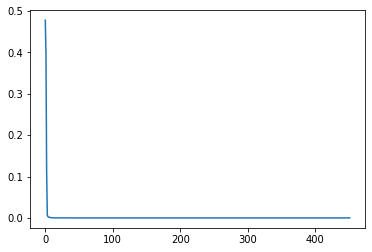

In [9]:
plt.plot(var)